In [20]:
import os
import subprocess

os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

# 경로 설정 - 한 환자의 func2 폴더에 있는 첫 번째 볼륨을 사용

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz'  
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/FSLSample'

fmri_img = nib.load(fmri_file)
first_volume = nib.Nifti1Image(fmri_img.dataobj[..., 0], fmri_img.affine)
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_path)

# BET2를 사용하여 Brain Extraction 및 마스크 생성
bet_output = os.path.join(output_dir, "bet_output")
bet_command = f"bet2 {first_volume_path} {bet_output} -f 0.3 -m"

try:
    subprocess.run(bet_command, shell=True, check=True)
    print("BET2 completed successfully.")
except subprocess.CalledProcessError as e:
    print(f"BET2 failed with error: {e}")
    exit(1)

mask_path = f"{bet_output}_mask.nii.gz"
mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata()

fmri_data = fmri_img.get_fdata()
masked_fmri_data = fmri_data * mask_data[..., np.newaxis] 

masked_fmri_img = nib.Nifti1Image(masked_fmri_data, fmri_img.affine, fmri_img.header)
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")
nib.save(masked_fmri_img, masked_fmri_path)

print(f"Masked fMRI data saved to: {masked_fmri_path}")

BET2 completed successfully.
Masked fMRI data saved to: /home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/FSLSample/masked_fmri.nii.gz


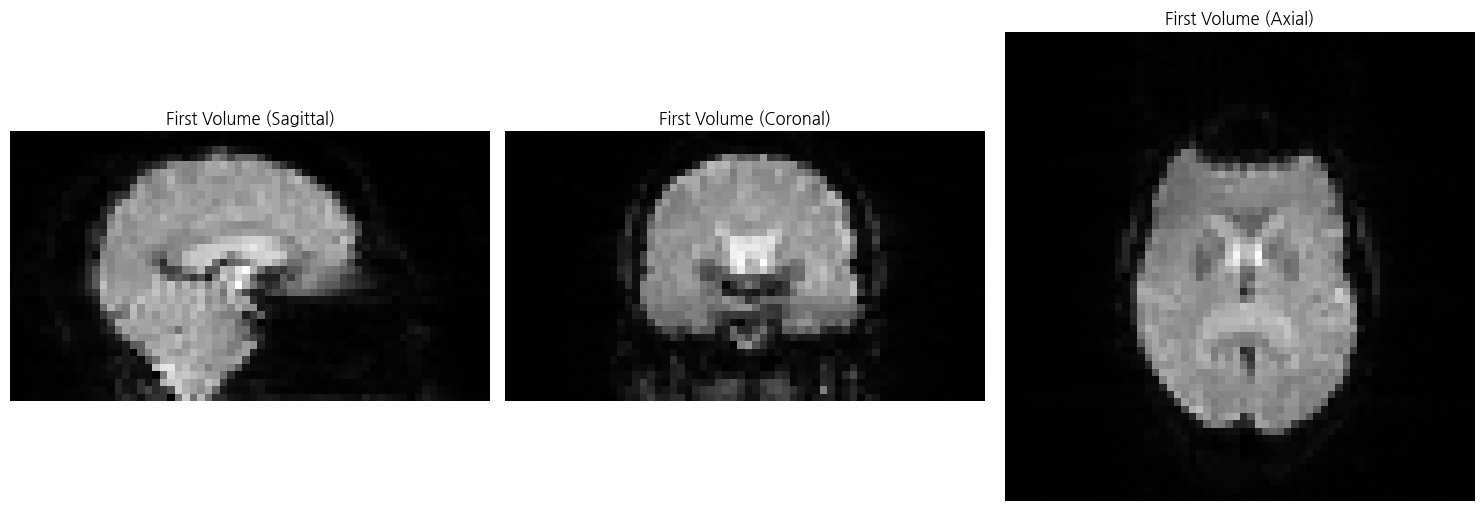

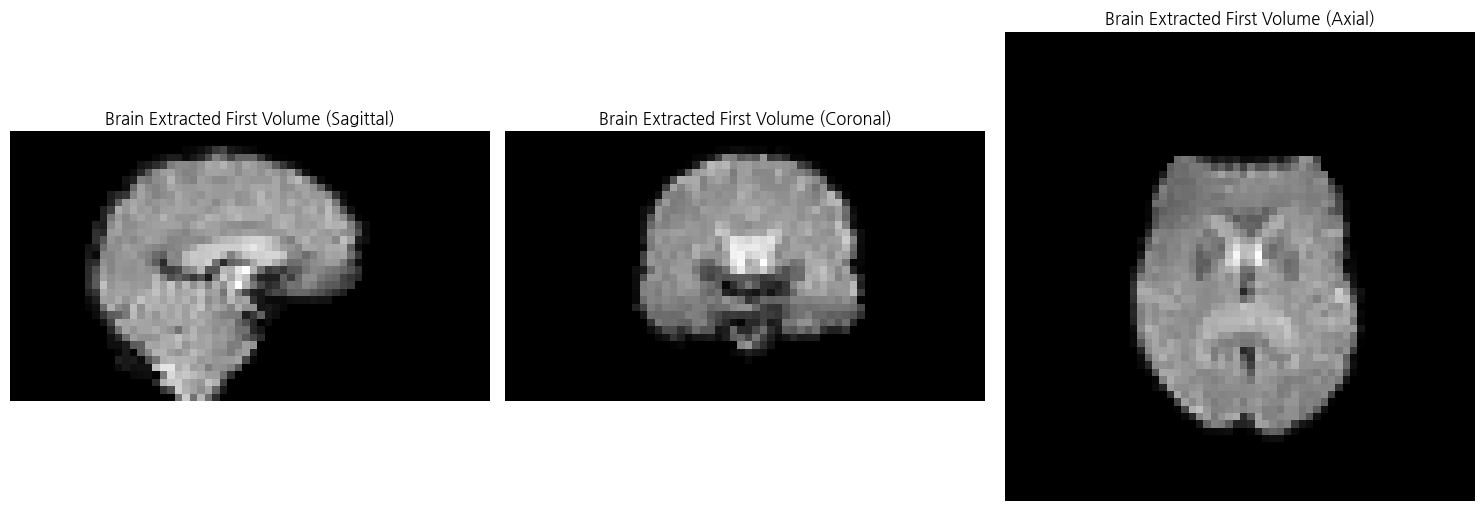

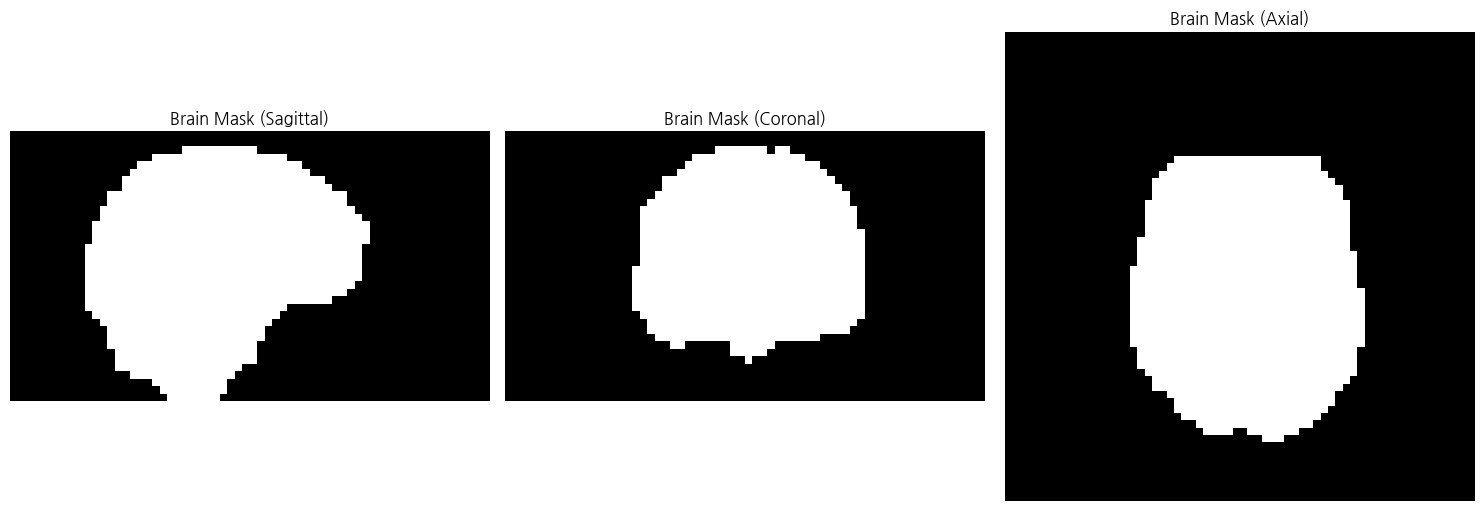

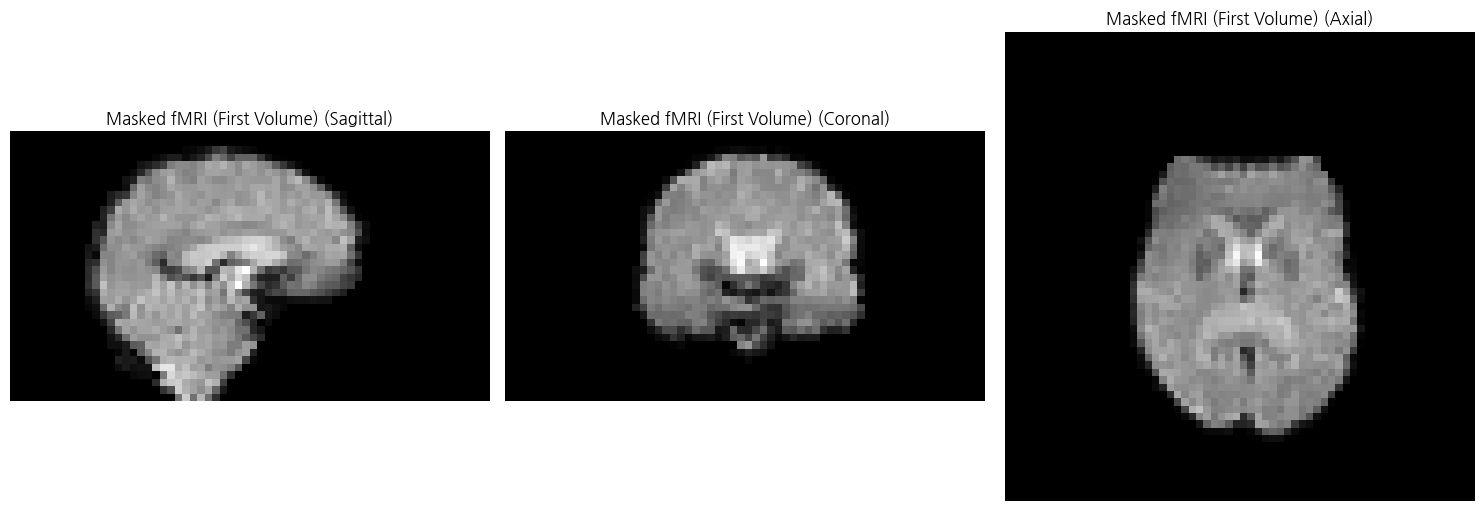

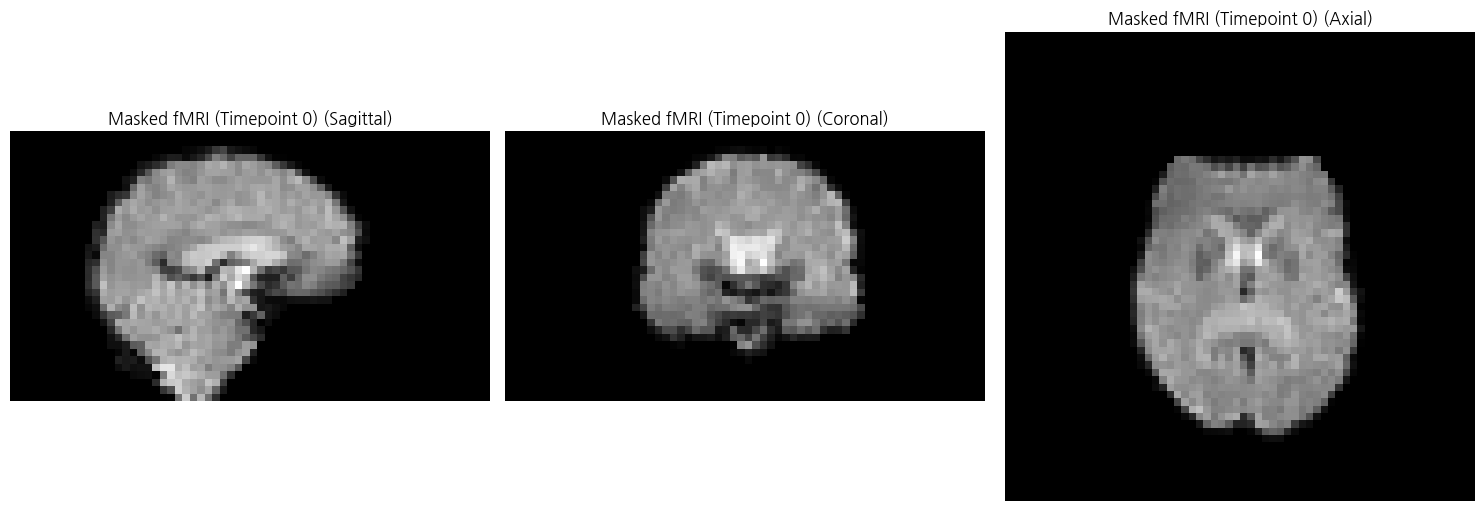

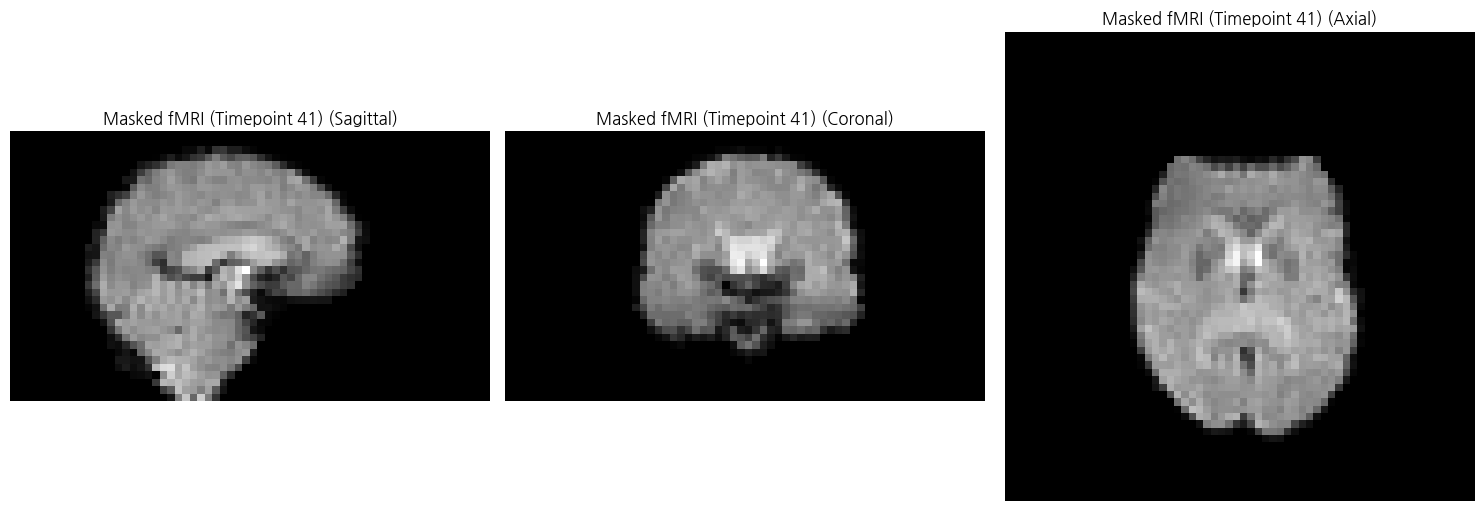

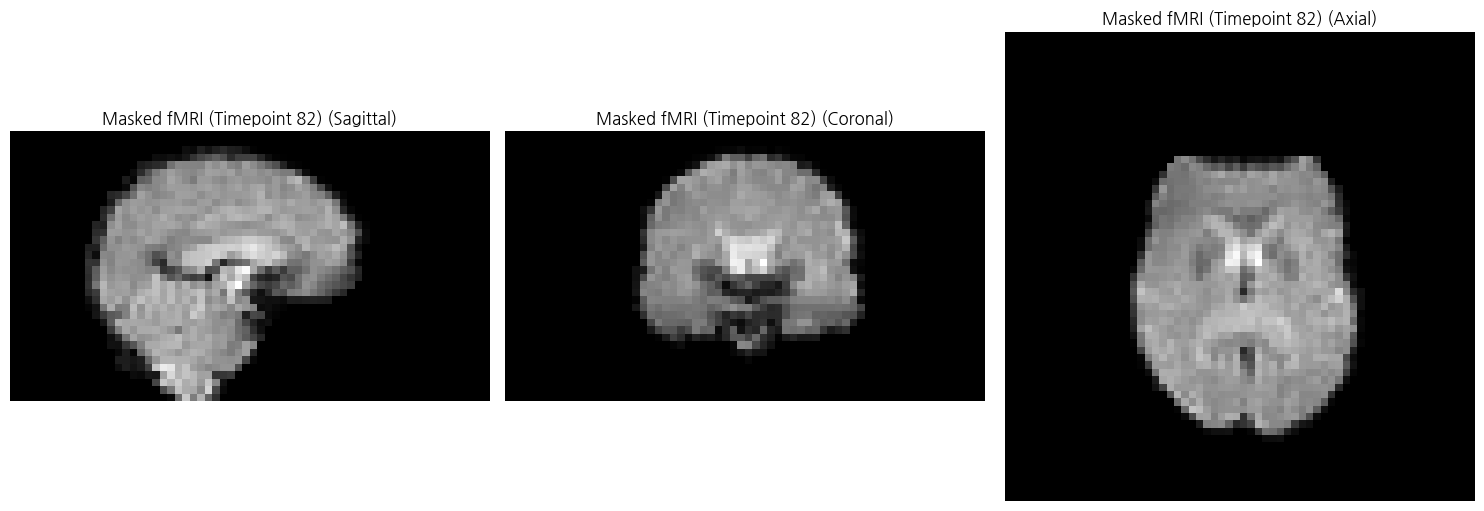

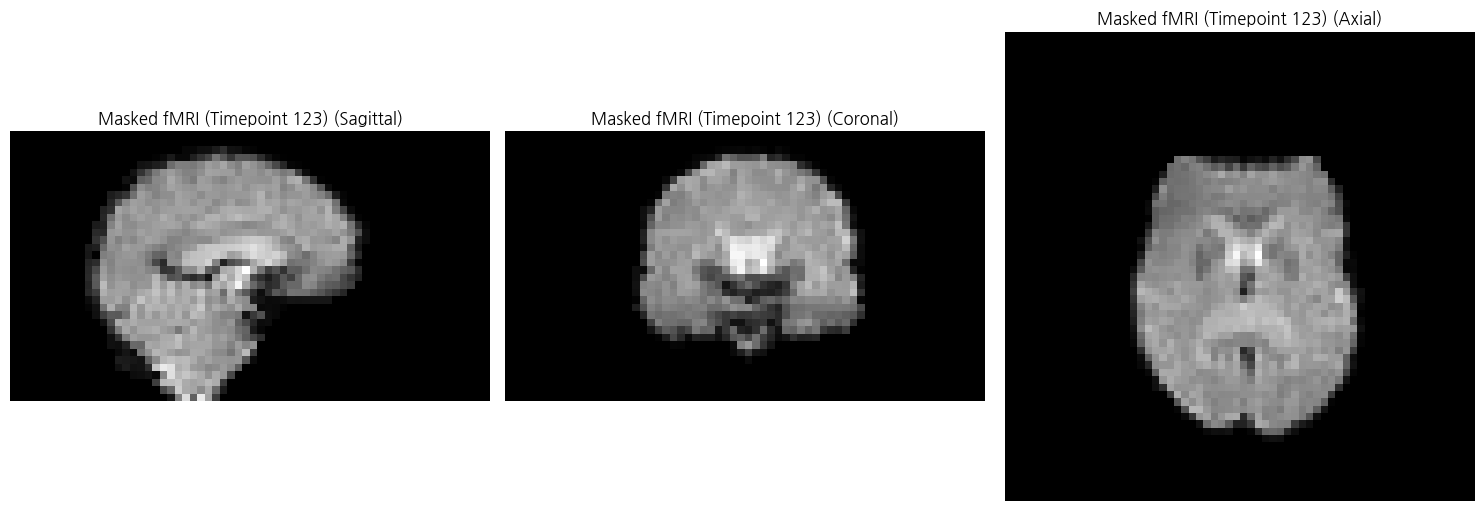

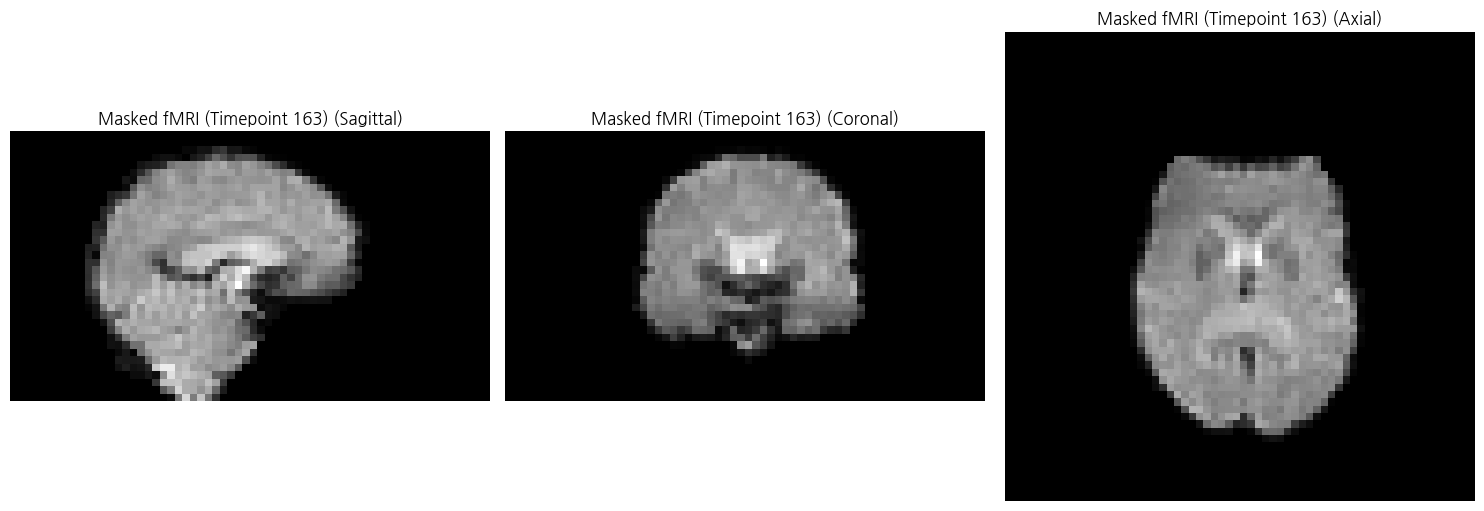

In [22]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def plot_middle_slice(img, title, time_point=0):
    data = img.get_fdata()
    if data.ndim == 4:
        data = data[..., time_point] 
    
    middle_slice_x = data.shape[0] // 2
    middle_slice_y = data.shape[1] // 2
    middle_slice_z = data.shape[2] // 2
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.imshow(data[middle_slice_x, :, :].T, cmap='gray', origin='lower')
    ax1.set_title(f'{title} (Sagittal)')
    ax1.axis('off')
    
    ax2.imshow(data[:, middle_slice_y, :].T, cmap='gray', origin='lower')
    ax2.set_title(f'{title} (Coronal)')
    ax2.axis('off')
    
    ax3.imshow(data[:, :, middle_slice_z].T, cmap='gray', origin='lower')
    ax3.set_title(f'{title} (Axial)')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

# 파일 경로 설정
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/FSLSample'
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
bet_output = os.path.join(output_dir, "bet_output")
mask_path = f"{bet_output}_mask.nii.gz"
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")

# 결과 시각화
plot_middle_slice(nib.load(first_volume_path), "First Volume")
plot_middle_slice(nib.load(f"{bet_output}.nii.gz"), "Brain Extracted First Volume")
plot_middle_slice(nib.load(mask_path), "Brain Mask")
plot_middle_slice(nib.load(masked_fmri_path), "Masked fMRI (First Volume)", time_point=0)

masked_fmri = nib.load(masked_fmri_path)
num_timepoints = masked_fmri.shape[3]
timepoints_to_show = [0, num_timepoints//4, num_timepoints//2, 3*num_timepoints//4, num_timepoints-1]

for tp in timepoints_to_show:
    plot_middle_slice(masked_fmri, f"Masked fMRI (Timepoint {tp})", time_point=tp)

## Extrated fMRI -> T1w 

Structural Brain Extraction completed successfully.


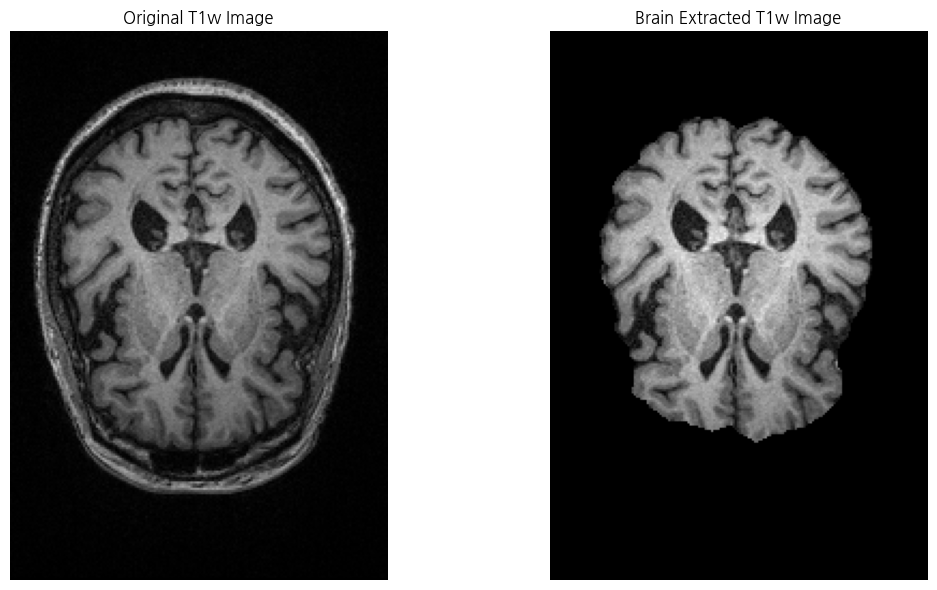

Structural brain extraction results saved to: /home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/FSLSample/struct_brain.nii.gz


In [26]:
import os
import subprocess
import nibabel as nib
import matplotlib.pyplot as plt

# 환경 설정
os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

# 파일 경로 설정
struct_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/anat2/NIFTI/sub-OAS30011_ses-d0055_T1w.nii.gz'
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/FSLSample'

# 구조적 이미지에 대한 Brain Extraction 수행
struct_brain_file = os.path.join(output_dir, "struct_brain.nii.gz")
bet_struct_command = f"bet2 {struct_file} {struct_brain_file} -f 0.5 -m"

try:
    subprocess.run(bet_struct_command, shell=True, check=True)
    print("Structural Brain Extraction completed successfully.")
except subprocess.CalledProcessError as e:
    print(f"Structural Brain Extraction failed with error: {e}")
    exit(1)

# 결과 시각화
def plot_brain_extraction(original_file, extracted_file, slice_num=None):
    original_img = nib.load(original_file)
    extracted_img = nib.load(extracted_file)
    
    original_data = original_img.get_fdata()
    extracted_data = extracted_img.get_fdata()
    
    if slice_num is None:
        slice_num = original_data.shape[2] // 2
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(original_data[:, :, slice_num].T, cmap='gray')
    ax1.set_title('Original T1w Image')
    ax1.axis('off')
    
    ax2.imshow(extracted_data[:, :, slice_num].T, cmap='gray')
    ax2.set_title('Brain Extracted T1w Image')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# 결과 시각화 실행
plot_brain_extraction(struct_file, struct_brain_file)

print(f"Structural brain extraction results saved to: {struct_brain_file}")

In [27]:
import os
import subprocess
import nibabel as nib
import numpy as np

# 환경 설정
os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

# 파일 경로 설정
fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/anat2/NIFTI/sub-OAS30011_ses-d0055_T1w.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'

os.makedirs(output_dir, exist_ok=True)

# 1. fMRI의 첫 번째 볼륨 추출 및 BET 적용
fmri_img = nib.load(fmri_file)
first_volume = nib.Nifti1Image(fmri_img.dataobj[..., 0], fmri_img.affine)
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_path)

bet_output = os.path.join(output_dir, "bet_output")
bet_command = f"bet {first_volume_path} {bet_output} -f 0.3 -m"
subprocess.run(bet_command, shell=True, check=True)

# 2. 마스크를 전체 fMRI 데이터에 적용
mask_img = nib.load(f"{bet_output}_mask.nii.gz")
mask_data = mask_img.get_fdata()
fmri_data = fmri_img.get_fdata()
masked_fmri_data = fmri_data * mask_data[..., np.newaxis]
masked_fmri_img = nib.Nifti1Image(masked_fmri_data, fmri_img.affine, fmri_img.header)
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")
nib.save(masked_fmri_img, masked_fmri_path)

# 3. FLIRT를 사용한 Functional-to-structural registration
flirt_output = os.path.join(output_dir, "func_to_struct")
flirt_command = f"flirt -in {masked_fmri_path} -ref {t1_file} -out {flirt_output} -omat {flirt_output}.mat -cost corratio -dof 6 -interp trilinear"
subprocess.run(flirt_command, shell=True, check=True)

# 4. FNIRT를 사용한 MNI 152 registration
fnirt_output = os.path.join(output_dir, "func_to_mni")
fnirt_command = f"fnirt --in={t1_file} --ref={mni_template} --aff={flirt_output}.mat --cout={fnirt_output}_warp"
subprocess.run(fnirt_command, shell=True, check=True)

# 5. 왜곡 필드를 fMRI 데이터에 적용
apply_warp_command = f"applywarp --in={masked_fmri_path} --ref={mni_template} --warp={fnirt_output}_warp --out={fnirt_output}"
subprocess.run(apply_warp_command, shell=True, check=True)

print("fMRI preprocessing pipeline completed successfully.")

fMRI preprocessing pipeline completed successfully.


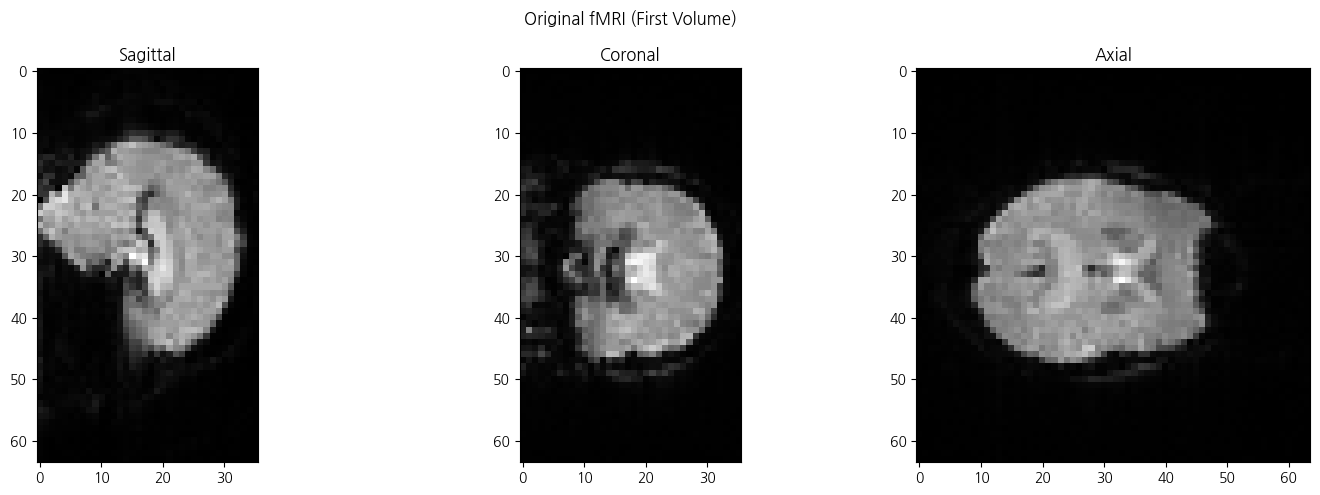

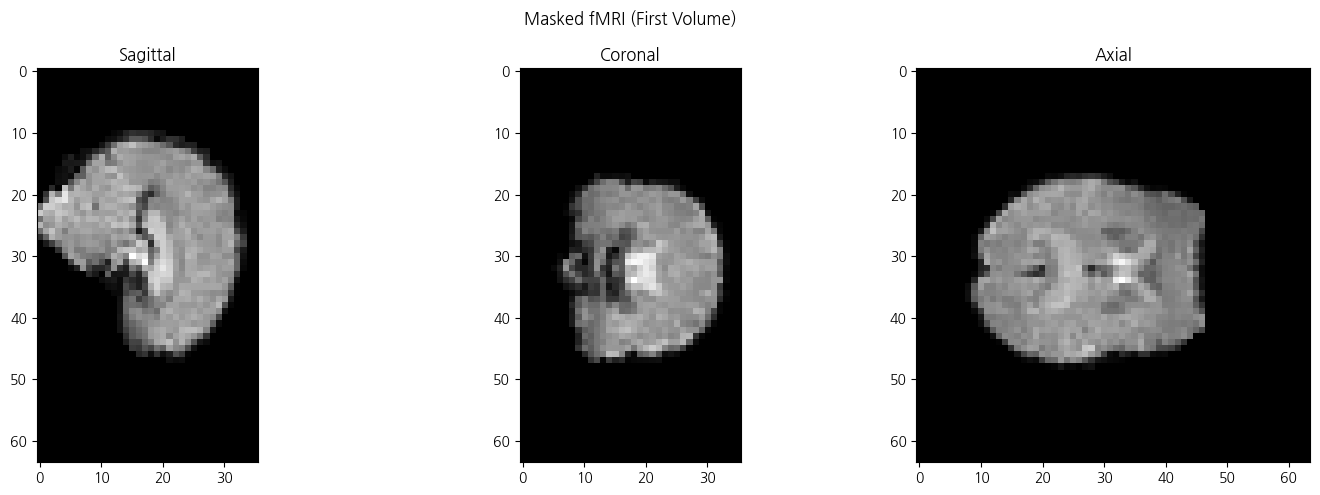

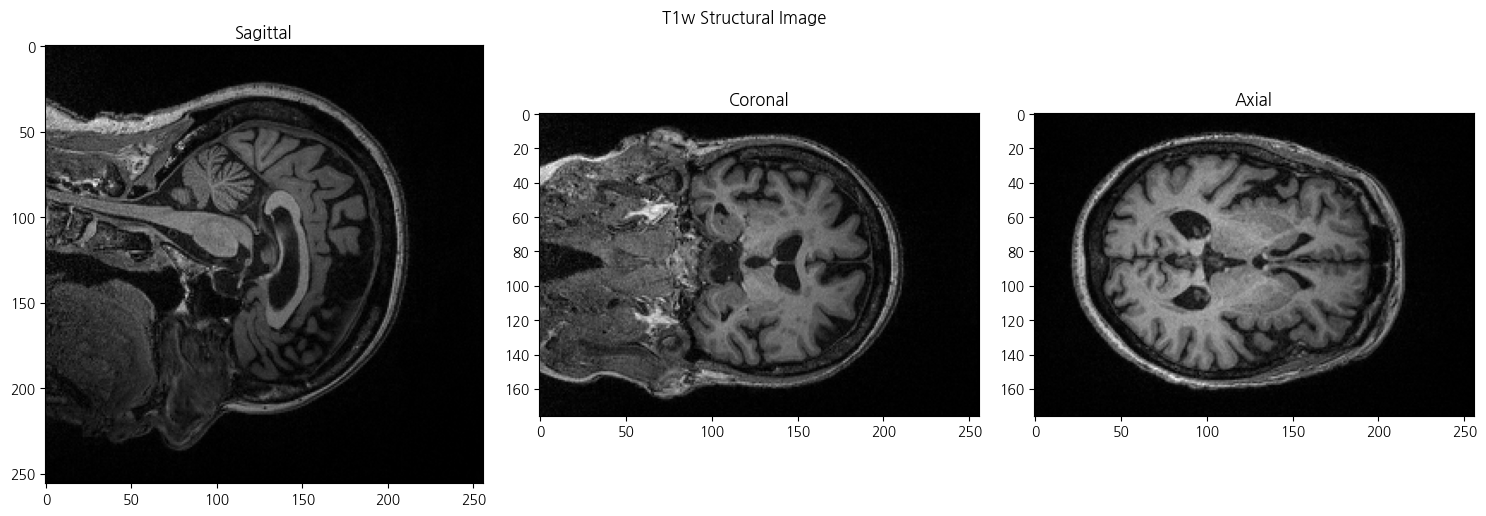

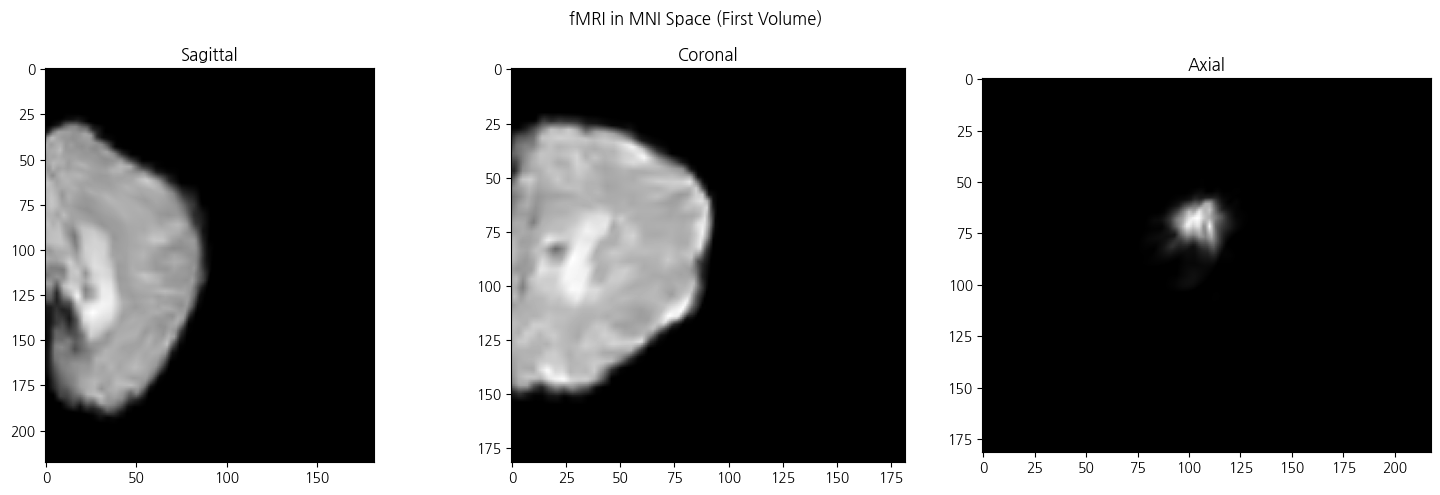

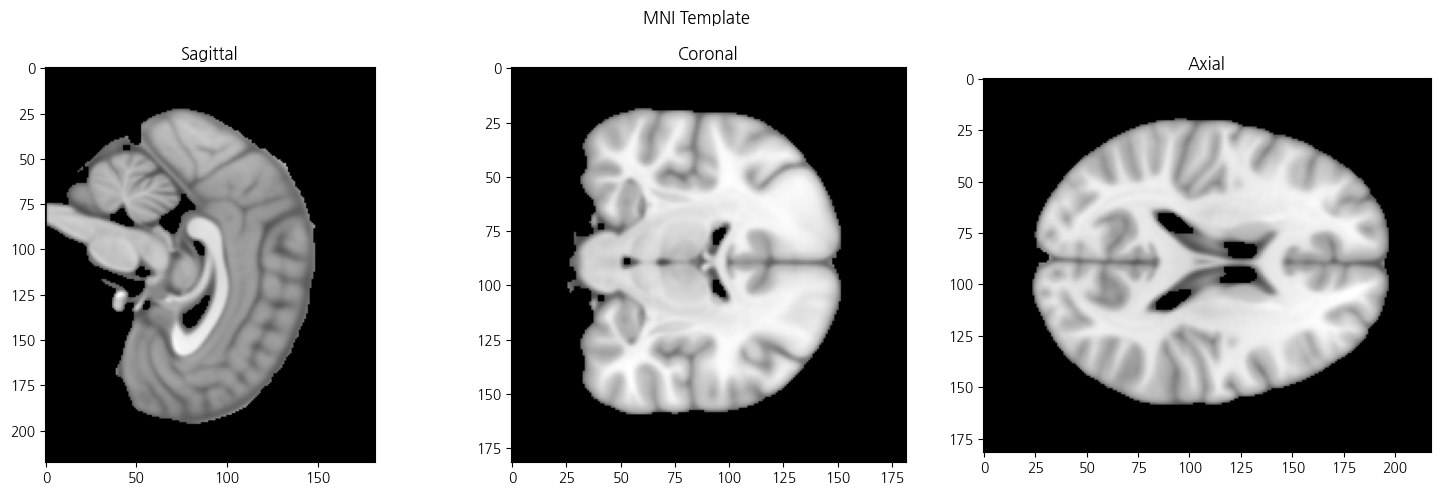

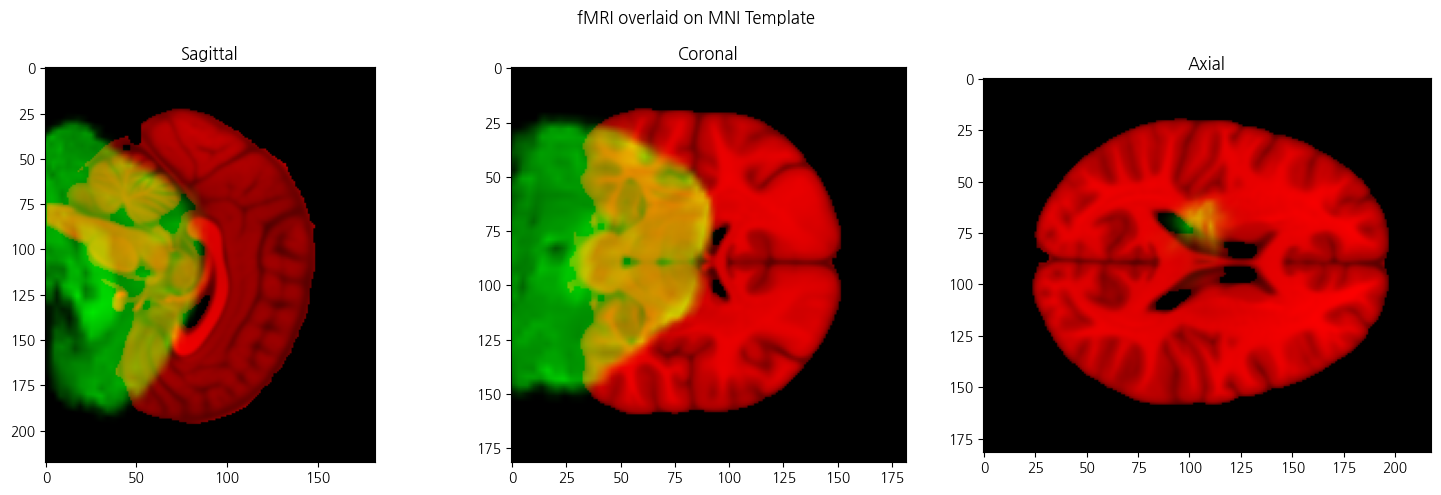

In [29]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def plot_slices(data, title, cmap='gray'):
    """Plot middle slices of 3D volume"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    midpoint = [s // 2 for s in data.shape]
    ax1.imshow(data[midpoint[0], :, :], cmap=cmap, aspect='equal')
    ax2.imshow(data[:, midpoint[1], :], cmap=cmap, aspect='equal')
    ax3.imshow(data[:, :, midpoint[2]], cmap=cmap, aspect='equal')
    ax1.set_title('Sagittal')
    ax2.set_title('Coronal')
    ax3.set_title('Axial')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# 파일 경로 설정 (실제 경로로 수정 필요)
fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz'
masked_fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample/masked_fmri.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/anat2/NIFTI/sub-OAS30011_ses-d0055_T1w.nii.gz'
mni_fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample/func_to_mni.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')

fmri_img = nib.load(fmri_file)
fmri_data = fmri_img.get_fdata()
plot_slices(fmri_data[:,:,:,0], 'Original fMRI (First Volume)')

masked_fmri_img = nib.load(masked_fmri_file)
masked_fmri_data = masked_fmri_img.get_fdata()
plot_slices(masked_fmri_data[:,:,:,0], 'Masked fMRI (First Volume)')

t1_img = nib.load(t1_file)
t1_data = t1_img.get_fdata()
plot_slices(t1_data, 'T1w Structural Image')

mni_fmri_img = nib.load(mni_fmri_file)
mni_fmri_data = mni_fmri_img.get_fdata()
plot_slices(mni_fmri_data[:,:,:,0], 'fMRI in MNI Space (First Volume)')

mni_template_img = nib.load(mni_template)
mni_template_data = mni_template_img.get_fdata()
plot_slices(mni_template_data, 'MNI Template')

overlay = np.zeros(mni_template_data.shape + (3,))
overlay[..., 0] = mni_template_data / np.max(mni_template_data)
overlay[..., 1] = mni_fmri_data[:,:,:,0] / np.max(mni_fmri_data[:,:,:,0])
plot_slices(overlay, 'fMRI overlaid on MNI Template', cmap=None)